<a href="https://colab.research.google.com/github/harikrishnareddymallavarapu/Masters/blob/main/Masters_5_NMF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install pyLDAvis==2.1.2
!python -m spacy download en_core_web_md

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive
Mounted at /content/drive


In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
import pickle
pkl_file = open('drive/My Drive/Top-Ex/articles_cleansed.pkl', 'rb')
articles = pickle.load(pkl_file)
pkl_file.close()

In [ ]:
print(articles.head())

                                         cleanseText                                       cleanseText2
0  [house, republicans, fret, win, health, care, ...  [house, republicans, fret, win, health, care, ...
1  [rift, officer, resident, killing, persist, so...  [rift, officer, resident, killing, persist, so...
2  [tyrus, wong, bambi, artist, thwart, racial, b...  [tyrus, wong, ,, ', bambi, ', artist, thwart, ...
3  [death, 2016, heavy, toll, pop, music, new, yo...  [death, 2016, ,, heavy, toll, pop, music, -, n...
4  [kim, jong, un, say, north, korea, prepare, te...  [kim, jong, -, un, say, north, korea, prepare,...


In [ ]:
# let us see the top 20 again after cleaning
articles['cleanseText2'] = articles.cleanseText.apply(lambda x: ' '.join(w for w in x))  

freq_NN = pd.Series(' '.join(articles['cleanseText2']).split()).value_counts()[:20]
freq_NN

say          258577
trump        160920
not           97924
mr            86574
be            84027
people        78751
new           73389
year          67666
president     63552
do            62916
clinton       57356
state         56897
like          53920
go            53063
time          53016
tell          48512
the           44412
know          43288
come          42325
report        40584
dtype: int64

In [ ]:
#Use CountVectorizer to get bigrams to visualize
#Use CountVectorizer to get bigrams to visualize
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_df = 0.95, min_df = 2, max_features=10000, ngram_range=(1,3))
X = cv.fit_transform(articles['cleanseText2'])

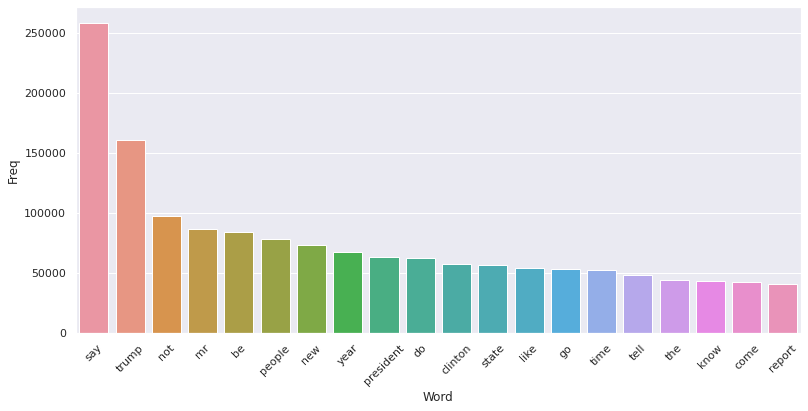

In [ ]:
# Most frequently occuring words
def get_top_n_words(corpus,n=None):
    vec = CountVectorizer().fit(articles['cleanseText2'])
    bag_of_words=vec.transform(articles['cleanseText2'])
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word , idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
# Convert most freq words to datafame for visuals

top_words = get_top_n_words(articles['cleanseText2'], n=20)
top_df = pd.DataFrame(top_words)
top_df.columns = ['Word', 'Freq']

# barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,6)})
g = sns.barplot(x='Word', y='Freq', data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
fig = g.get_figure()
fig.savefig("sns_output.png")


In [ ]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

# use tfidf by removing tokens that don't appear in at least 50 documents
vect = TfidfVectorizer(min_df=50, stop_words='english')

# Fit and transform
X = vect.fit_transform(articles['cleanseText2'])

In [ ]:
# Create an NMF instance: model
# the 10 components will be the topics
model = NMF(n_components=10, random_state=5)
# Fit the model to TF-IDF
model.fit(X)
# Transform the TF-IDF: nmf_features
nmf_features = model.transform(X)

In [ ]:
components_df = pd.DataFrame(model.components_, columns=vect.get_feature_names())
components_df

,00,000,08,10,100,1000,100th,101,102,103,104,105,106,107,108,109,10th,11,110,111,112,113,114,115,116,117,118,119,11th,12,120,122,123,124,125,126,127,128,129,12th,...,yield,yildirim,yoga,yogurt,york,yorker,yorkers,yorkshire,yougov,young,younger,youngster,youngstown,youth,youthful,youtube,ypg,yuan,yuri,zach,zachary,zakaria,zeal,zealand,zeitung,zeke,zero,zetas,zhang,zika,zimbabwe,zimmerman,zinke,zionist,zip,zombie,zone,zoo,zoom,zuckerberg
0,0.002316,0.134264,0.004099,0.197925,0.103245,0.005446,0.005676,0.006455,0.003815,0.003933,0.001240,0.007549,1.882087e-03,0.002461,0.004065,0.000425,0.016299,0.088592,0.006175,0.001319,0.001428,0.001121,0.002525,0.004576,0.000893,0.001943,0.000908,0.001857,0.014963,0.094361,0.006686,0.000841,0.001646,0.001004,0.062787,0.001484,0.001704,0.002084,0.001141,0.012980,...,0.006376,0.000000,0.021636,0.006374,0.383705,0.020709,0.017699,0.004913,0.001070,0.387777,0.004871,0.008083,0.000118,0.062101,0.009731,0.087604,0.000000,0.000000,0.003277,0.012336,0.003365,0.001036,0.002514,0.025339,0.000000,0.001084,0.026325,0.000000,0.006645,0.065640,0.006971,0.004036,0.000000,0.003508,0.008436,0.014086,0.040910,0.036225,0.005123,0.072850
1,0.000000,0.000000,0.000000,0.000000,0.022243,0.000000,0.005508,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.004381,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000301,0.000000,0.000000,0.000000,0.000000,0.000000,0.002241,0.000000,0.000000,0.000000,0.010015,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.060450,0.011126,0.000763,0.000000,0.000000,0.000000,0.000000,0.000000,0.001942,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013422,0.000002,0.000000,0.000000,0.003954,0.006665,0.000000,0.000000,0.000000,0.000000,0.000000,0.006816,0.000600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.002465,0.000000,0.005864,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000040,0.000000,0.000000e+00,0.000000,0.000135,0.000740,0.000000,0.010562,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000094,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000563,0.000000,0.000000,0.000000,...,0.000618,0.000199,0.000000,0.000206,0.271073,0.006283,0.005555,0.000451,0.000000,0.028372,0.000718,0.000000,0.005108,0.003953,0.002204,0.000000,0.000000,0.000000,0.001079,0.000000,0.000477,0.000000,0.002302,0.004213,0.000000,0.000000,0.002683,0.000000,0.001386,0.000000,0.004950,0.000000,0.005596,0.001053,0.001105,0.000000,0.000157,0.000628,0.000000,0.000000
3,0.000444,0.071361,0.003820,0.013876,0.009286,0.000635,0.000000,0.000296,0.001275,0.001267,0.000000,0.000099,0.000000e+00,0.000690,0.001688,0.000000,0.000000,0.031423,0.002542,0.000000,0.002429,0.000275,0.000000,0.000000,0.001407,0.000169,0.000000,0.000000,0.000414,0.015500,0.000000,0.000000,0.000603,0.000000,0.018277,0.000024,0.000000,0.000093,0.000000,0.000000,...,0.000000,0.000000,0.006189,0.001415,0.095139,0.007927,0.003836,0.000000,0.000211,0.020839,0.000623,0.000000,0.002864,0.002100,0.000000,0.005907,0.000000,0.000000,0.000000,0.000904,0.000000,0.000000,0.000000,0.000000,0.000000,0.000581,0.006394,0.000000,0.000000,0.000000,0.000000,0.000224,0.000000,0.000000,0.000000,0.000000,0.005597,0.000000,0.000000,0.000000
4,0.000183,0.127352,0.000000,0.037088,0.030641,0.001159,0.000000,0.001617,0.000076,0.001124,0.001606,0.000135,0.000000e+00,0.000000,0.000754,0.001155,0.000000,0.033406,0.004910,0.000819,0.001885,0.001673,0.001053,0.000579,0.000000,0.001652,0.000677,0.001160,0.004765,0.029738,0.015037,0.001436,0.000736,0.000429,0.010113,0.000656,0.000000,0.000417,0.001107,0.000865,...,0.003027,0.013878,0.000000,0.000770,0.000000,0.000000,0.000000,0.001497,0.000977,0.028909,0.000420,0.000734,0.001274,0.014494,0.000272,0.000866,0.053659,0.000000,0.000939,0.000000,0.000000,0.010556,0.001822,0.005386,0.009252,0.000000,0.003225,0.000000,0.000000,0.000000,

In [ ]:
for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 1 the words with the highest value are:
say       1.583235
woman     1.067660
people    0.993179
like      0.963585
think     0.767965
know      0.742464
year      0.707864
time      0.699392
new       0.674255
life      0.630757
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
trump           4.439826
donald          0.913732
president       0.729379
campaign        0.460629
say             0.440229
republican      0.373484
obama           0.303542
white           0.294983
presidential    0.264264
nominee         0.254776
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
mr         4.406794
ms         0.519792
say        0.514895
mrs        0.421247
york       0.271073
new        0.263857
times      0.225928
party      0.178796
senator    0.126818
united     0.124712
Name: 2, dtype: float64


For topic 4 the words with the highest value are:
clinton       4.258563
hillary       1.570420
email         0.628591
campaign     

In [ ]:
pkl_file = open('drive/My Drive/Top-Ex/lda_data_lemmatized.pkl', 'rb')
data_lemmatized = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('drive/My Drive/Top-Ex/lda_id2word.pkl', 'rb')
id2word = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('drive/My Drive/Top-Ex/lda_corpus.pkl', 'rb')
corpus = pickle.load(pkl_file)
pkl_file.close()

In [ ]:
!pip install gensim

In [ ]:
import gensim.downloader
from gensim import matutils, utils
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel, TfidfModel
from gensim.models.basemodel import BaseTopicModel
from gensim.models.nmf import Nmf as GensimNmf
from gensim.parsing.preprocessing import preprocess_string

ModuleNotFoundError: ignored

In [ ]:
from gensim.models.nmf import Nmf
nmf = Nmf(corpus, num_topics=50, kappa=0.1, eval_every=5) 

ModuleNotFoundError: ignored

In [ ]:
# Most frequently occuring words
def get_top_n_words(corpus,n=None):
    vec = CountVectorizer().fit(df1['cleaned'])
    bag_of_words=vec.transform(df1['cleaned'])
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word , idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
# Convert most freq words to datafame for visuals

top_words = get_top_n_words(df1['cleaned'], n=20)
top_df = pd.DataFrame(top_words)
top_df.columns = ['Word', 'Freq']

# barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,6)})
g = sns.barplot(x='Word', y='Freq', data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
fig = g.get_figure()
fig.savefig("sns_output.png")